# Importation des packages

In [2]:
import numpy as np
import pandas as pd
import cv2
from imutils import contours
import os
import matplotlib.pyplot as plt
from glob import glob

# Transformation vidéo en images

In [3]:
# Importing all necessary libraries
import cv2
import os

# Read the video from specified path

def video_to_images(file_name, 
                    outpout_folder_name):
    cam = cv2.VideoCapture(file_name)
    
    data = np.array([])

    try:
        
        # creating a folder named data
        if not os.path.exists(outpout_folder_name):
            os.makedirs(outpout_folder_name)
    
    # if not created then raise error
    except OSError:
        print ('Error: Creating directory of data')
    
    # frame
    currentframe = 0
    
    while(True):
        
        # reading from frame
        ret,frame = cam.read()
    
        if ret:
            # if video is still left continue creating images
            name = f'./{outpout_folder_name}/frame' + str(currentframe) + '.jpg'
            #print ('Creating...' + name)
            data = np.append(data, name)
            # writing the extracted images
            cv2.imwrite(name, frame)
    
            # increasing counter so that it will
            # show how many frames are created
            currentframe += 1
        else:
            break
    
    # Release all space and windows once done
    cam.release()
    cv2.destroyAllWindows()

    return data

# Function

In [4]:
def transform_image_into_matrix(board_game_image:np.ndarray, threshold_intensity=70, threshold_header=66)->np.ndarray:
    """ 
    Transform image of tetris into 20x10 matrix

    Args:
        image(np.ndarray): image of the board game

    Returns:
        np.ndarray: matrix 20x10 of the board game
    """

    game_board = board_game_image[threshold_header:, :, :]
    resize_image = cv2.resize(game_board, (10, 20), interpolation = cv2.INTER_AREA)
    resize_image_sum = np.sum(resize_image, axis=-1)
    thresh_resize_image = np.where(resize_image_sum>threshold_intensity, 255, 0)

    return thresh_resize_image

In [5]:
def transform_next_tetromino_to_matrix(board_game_image:np.ndarray, threshold_intensity=70)->np.ndarray:
    """ 
    Transform game image of tetris into the next tetromino with a 5x2 matrix

    Args:
        image(np.ndarray): image of the board game

    Returns:
        np.ndarray: matrix 5x2 of the next tetromino
    """

    game_board_next_tetromino = board_game_image[:58, 158:, :]
  
    resize_image = cv2.resize(game_board_next_tetromino, (5, 2), interpolation = cv2.INTER_AREA)

    resize_image_sum = np.sum(resize_image, axis=-1)

    thresh_resize_image = np.where(resize_image_sum>threshold_intensity, 255, 0)
    #plt.imshow(thresh_resize_image)
    #plt.show()

    return thresh_resize_image

In [6]:
def test_transform_next_tetromino_to_matrix():
    """
    Test the function transform_next_tetromino_to_matrix
    """

    path_right_snake = 'data/frame167.jpg'
    right_snake_image = cv2.imread(path_right_snake)
    next_tetromino_matrix = transform_next_tetromino_to_matrix(right_snake_image)
    assert np.array_equal(next_tetromino_matrix, [[0, 0, 255, 255, 0],
                                    [0, 255, 255, 0, 0]])
    
    path_left_snake = 'data/frame289.jpg'
    left_snake_image = cv2.imread(path_left_snake)
    next_tetromino_matrix = transform_next_tetromino_to_matrix(left_snake_image)
    assert np.array_equal(next_tetromino_matrix, [[0, 255, 255, 0, 0],
                                    [0, 0, 255, 255, 0]])

    path_right_gun = 'data/frame98.jpg' 
    right_gun_image = cv2.imread(path_right_gun)

    next_tetromino_matrix = transform_next_tetromino_to_matrix(right_gun_image)

    assert np.array_equal(next_tetromino_matrix, [[0, 255, 255, 255, 0],
                                    [0, 255, 0, 0, 0]])

    path_left_gun = 'data/frame67.jpg'
    left_gun_image = cv2.imread(path_left_gun)

    next_tetromino_matrix = transform_next_tetromino_to_matrix(left_gun_image)
    assert np.array_equal(next_tetromino_matrix, [[0, 255, 255, 255, 0],
                                    [0, 0, 0, 255, 0]])

    path_square = 'data/frame347.jpg'
    square_image = cv2.imread(path_square)

    next_tetromino_matrix = transform_next_tetromino_to_matrix(square_image)
    assert np.array_equal(next_tetromino_matrix, [[0, 255, 255, 255, 0],
                                    [0, 255, 255, 255, 0]])

    path_hat = 'data/frame0.jpg'
    hat_image = cv2.imread(path_hat)

    next_tetromino_matrix = transform_next_tetromino_to_matrix(hat_image)
    assert np.array_equal(next_tetromino_matrix, [[0, 255, 255, 255, 0],
                                    [0, 0, 255, 0, 0]])

    path_long = 'data/frame35.jpg' 
    long_image = cv2.imread(path_long)

    next_tetromino_matrix = transform_next_tetromino_to_matrix(long_image)
    assert np.array_equal(next_tetromino_matrix, [[255, 255, 255, 255, 255],
                                    [255, 255, 255, 255, 255]])


In [7]:
def detect_tetromino(tetromino_matrix:np.ndarray)->str:
    """
    Detect tetromino from tetromino matrix 5x2

    Args:
        tetromino(np.ndarray): matrix 5x2 of the tetromino

    Returns:
        str: name of the tetromino
    """

    match tetromino_matrix:
        case _ if np.array_equal(tetromino_matrix, [[0, 0, 255, 255, 0], [0, 255, 255, 0, 0]]):
            return 'right_snake'
        case _ if np.array_equal(tetromino_matrix, [[0, 255, 255, 0, 0], [0, 0, 255, 255, 0]]):
            return 'left_snake'    
        case _ if np.array_equal(tetromino_matrix, [[0, 255, 255, 255, 0], [0, 255, 0, 0, 0]]):
            return 'right_gun'    
        case _ if np.array_equal(tetromino_matrix, [[0, 255, 255, 255, 0], [0, 0, 0, 255, 0]]):
            return 'left_gun'  
        case _ if np.array_equal(tetromino_matrix, [[0, 255, 255, 255, 0], [0, 255, 255, 255, 0]]):
            return 'square'  
        case _ if np.array_equal(tetromino_matrix, [[0, 255, 255, 255, 0], [0, 0, 255, 0, 0]]):
            return 'hat'  
        case _ if np.array_equal(tetromino_matrix, [[255, 255, 255, 255, 255], [255, 255, 255, 255, 255]]):
            return 'long' 

In [8]:
def test_detect_tetromino():
    """
    Test the function detect_tetromino
    """

    path_right_snake = 'data/frame167.jpg'
    right_snake_image = cv2.imread(path_right_snake)
    next_tetromino_matrix = transform_next_tetromino_to_matrix(right_snake_image)
    tetromino_name = detect_tetromino(next_tetromino_matrix)
    assert tetromino_name == "right_snake"
    
    path_left_snake = 'data/frame289.jpg'
    left_snake_image = cv2.imread(path_left_snake)
    next_tetromino_matrix = transform_next_tetromino_to_matrix(left_snake_image)
    tetromino_name = detect_tetromino(next_tetromino_matrix)
    assert tetromino_name == "left_snake"

    path_right_gun = 'data/frame98.jpg' 
    right_gun_image = cv2.imread(path_right_gun)
    next_tetromino_matrix = transform_next_tetromino_to_matrix(right_gun_image)
    tetromino_name = detect_tetromino(next_tetromino_matrix)
    assert tetromino_name == "right_gun"

    path_left_gun = 'data/frame67.jpg'
    left_gun_image = cv2.imread(path_left_gun)
    next_tetromino_matrix = transform_next_tetromino_to_matrix(left_gun_image)
    tetromino_name = detect_tetromino(next_tetromino_matrix)
    assert tetromino_name == "left_gun"

    path_square = 'data/frame347.jpg'
    square_image = cv2.imread(path_square)
    next_tetromino_matrix = transform_next_tetromino_to_matrix(square_image)
    tetromino_name = detect_tetromino(next_tetromino_matrix)
    assert tetromino_name == "square"

    path_hat = 'data/frame0.jpg'
    hat_image = cv2.imread(path_hat)
    next_tetromino_matrix = transform_next_tetromino_to_matrix(hat_image)
    tetromino_name = detect_tetromino(next_tetromino_matrix)
    assert tetromino_name == "hat"

    path_long = 'data/frame35.jpg' 
    long_image = cv2.imread(path_long)
    next_tetromino_matrix = transform_next_tetromino_to_matrix(long_image)
    tetromino_name = detect_tetromino(next_tetromino_matrix)
    assert tetromino_name == "long"

In [9]:
test_detect_tetromino()

AssertionError: 

In [10]:
path ='data'

for image in data:
    x_image = cv2.imread(image)
    plt.imshow(x_image)
    plt.show()

    game_board_matrix = transform_image_into_matrix(x_image)
    plt.imshow(game_board_matrix)
    plt.show()   

    next_tetromino_matrix = transform_next_tetromino_to_matrix(x_image)
    next_tetromino_name = detect_tetromino(next_tetromino_matrix)

    print(next_tetromino_name)
    
    break

NameError: name 'data' is not defined

# Garder que les images intéressantes

In [11]:
def determined_is_tetromino_start(game_board_matrix:np.ndarray)->bool:
    '''
    is there a tetromino in the beginning part of the board? 
    '''

    return np.any(game_board_matrix[:4, :])


In [12]:
def test_determined_is_tetromino_start():
    ''' 
    Test function determined_is_tetromino_start
    '''

    is_tetromino_path = 'data/frame35.jpg' 
    is_tetromono = cv2.imread(is_tetromino_path)
    game_board_matrix = transform_image_into_matrix(is_tetromono)
    assert determined_is_tetromino_start(game_board_matrix) == True


    is_no_tetromino_path = 'data/frame53.jpg' 
    is_no_tetromino = cv2.imread(is_no_tetromino_path)
    game_board_matrix = transform_image_into_matrix(is_no_tetromino)
    assert determined_is_tetromino_start(game_board_matrix) == False

In [13]:
test_determined_is_tetromino_start()

In [14]:
def determined_is_clean_four_lines(game_board_matrix):


    return np.all(game_board_matrix)
    


In [15]:
is_no_tetromino_path = 'data/frame1787.jpg' 
is_no_tetromino = cv2.imread(is_no_tetromino_path)
game_board_matrix = transform_image_into_matrix(is_no_tetromino)
determined_is_clean_four_lines(game_board_matrix)

True

In [ ]:
is_no_tetromino_path = 'data/frame635.jpg' 
is_no_tetromino = cv2.imread(is_no_tetromino_path)
last_game_board_matrix = transform_image_into_matrix(is_no_tetromino)

is_no_tetromino_path = 'data/frame636.jpg' 
is_no_tetromino = cv2.imread(is_no_tetromino_path)
game_board_matrix = transform_image_into_matrix(is_no_tetromino)


print(np.any(last_game_board_matrix-game_board_matrix)>0)

In [16]:
def create_current_tetromino_dataframe(list_image:np.ndarray, threshold_intensity=70, threshold_header=66)->pd.DataFrame:
    """ 
    Create the dataframe of useable image to create training data.

    Args: 
        list_image(np.array): list of the game board image

    Returns:
        pd.DataFrame: dataframe of the usable image to create training dataframe
    """

    dataframe = pd.DataFrame([], columns=('image_path', 'x_y', 'id_pair'))

    id_pair = 0
    is_tetromino_start = True
    is_tetromino_start_last_image = False
    clear_four_lines = False
    for image_path in list_image:
        x_image = cv2.imread(image_path)

        game_board_matrix = transform_image_into_matrix(x_image, threshold_intensity=threshold_intensity, threshold_header=threshold_header)
    
        is_clear_four_lines = determined_is_clean_four_lines(game_board_matrix)

        if id_pair != 0 :
            slow_remove_line = np.any(np.sum(last_game_board_matrix-game_board_matrix)>0)
        else :
            slow_remove_line = False

        if not(is_clear_four_lines) and not(slow_remove_line):

            is_tetromino_start = determined_is_tetromino_start(game_board_matrix)

            

            if is_tetromino_start and is_tetromino_start != is_tetromino_start_last_image:

                if id_pair != 0 and not(clear_four_lines):
                    dataframe = pd.concat([dataframe, pd.DataFrame([[last_image_path, 'y', id_pair]], columns=('image_path', 'x_y', 'id_pair'))])
                else :
                    clear_four_lines = False
                id_pair += 1
                dataframe = pd.concat([dataframe, pd.DataFrame([[image_path, 'x', id_pair]], columns=('image_path', 'x_y', 'id_pair'))])

        elif is_clear_four_lines and not(clear_four_lines) :
            dataframe = pd.concat([dataframe, pd.DataFrame([[last_image_path, 'y', id_pair]], columns=('image_path', 'x_y', 'id_pair'))])
            clear_four_lines = True

        elif slow_remove_line and not(clear_four_lines):
            dataframe = pd.concat([dataframe, pd.DataFrame([[last_image_path, 'y', id_pair]], columns=('image_path', 'x_y', 'id_pair'))])
            clear_four_lines = True


        is_tetromino_start_last_image = is_tetromino_start
        last_image_path = image_path
        last_game_board_matrix = game_board_matrix


    dataframe = dataframe.reset_index(drop=True)

    if len(np.unique(dataframe.iloc[-2:, -1])) == 2:
        dataframe.drop(dataframe.iloc[-1:, :].index, axis=0, inplace=True)

    return dataframe

In [ ]:
dataframe = create_current_tetromino_dataframe(data)

In [ ]:
np.max(dataframe['id_pair'])

In [17]:
def get_start_column(matrix_difference):
    is_tetromino_column = np.sum(matrix_difference, axis=0)

    for id_column in np.arange(10):
        if is_tetromino_column[id_column] > 0:
            return id_column


In [18]:
def get_tetromino_from_difference(matrix_difference):
    # Find the indices where the tetromino starts and ends
    start_row, end_row = None, None
    start_col, end_col = None, None

    for i in range(matrix_difference.shape[0]):
        if np.any(matrix_difference[i] != 0):
            start_row = i
            break

    for i in range(matrix_difference.shape[0] - 1, -1, -1):
        if np.any(matrix_difference[i] != 0):
            end_row = i
            break

    for j in range(matrix_difference.shape[1]):
        if np.any(matrix_difference[:, j] != 0):
            start_col = j
            break

    for j in range(matrix_difference.shape[1] - 1, -1, -1):
        if np.any(matrix_difference[:, j] != 0):
            end_col = j
            break

    # Extract the tetromino
    tetromino = matrix_difference[start_row:end_row + 1, start_col:end_col + 1]

    return tetromino


In [19]:
def get_tetromino_name_and_rotation(current_tetromino_matrix):

    match current_tetromino_matrix:
        case _ if np.array_equal(current_tetromino_matrix, [[0, 255, 255], 
                                                            [255, 255, 0]]):
            return 'right_snake', 0
        case _ if np.array_equal(current_tetromino_matrix, [[255, 0], 
                                                            [255, 255],
                                                            [0, 255]]):
            return 'right_snake', 1
        

        case _ if np.array_equal(current_tetromino_matrix, [[255, 255, 0], 
                                                            [0, 255, 255]]):
            return 'left_snake', 0
        case _ if np.array_equal(current_tetromino_matrix, [[0, 255], 
                                                            [255, 255],
                                                            [255, 0]]):
            return 'left_snake', 1      
        
        case _ if np.array_equal(current_tetromino_matrix, [[0, 0, 255], 
                                                            [255, 255, 255]]):
            return 'right_gun', 0
        case _ if np.array_equal(current_tetromino_matrix, [[255, 0], 
                                                            [255, 0],
                                                            [255, 255]]):
            return 'right_gun', 1
        case _ if np.array_equal(current_tetromino_matrix, [[255, 255, 255], 
                                                            [255, 0, 0]]):
            return 'right_gun', 2
        case _ if np.array_equal(current_tetromino_matrix, [[255, 255], 
                                                            [0, 255],
                                                            [0, 255]]):
            return 'right_gun', 3

        case _ if np.array_equal(current_tetromino_matrix, [[255, 0, 0], 
                                                            [255, 255, 255]]):
            return 'left_gun', 0
        case _ if np.array_equal(current_tetromino_matrix, [[255, 255], 
                                                            [255, 0],
                                                            [255, 0]]):
            return 'left_gun', 1
        case _ if np.array_equal(current_tetromino_matrix, [[255, 255, 255], 
                                                            [0, 0, 255]]):
            return 'left_gun', 2
        case _ if np.array_equal(current_tetromino_matrix, [[0, 255], 
                                                            [0, 255],
                                                            [255, 255]]):
            return 'left_gun', 3
        

        case _ if np.array_equal(current_tetromino_matrix, [[255, 255], 
                                                            [255, 255]]):
            return 'square', 0

 
        case _ if np.array_equal(current_tetromino_matrix, [[0, 255, 0], 
                                                            [255, 255, 255]]):
            return 'hat', 0 
        case _ if np.array_equal(current_tetromino_matrix, [[255, 0], 
                                                            [255, 255], 
                                                            [255, 0]]):
            return 'hat', 1
        case _ if np.array_equal(current_tetromino_matrix, [[255, 255, 255], 
                                                            [0, 255, 0]]):
            return 'hat', 2
        case _ if np.array_equal(current_tetromino_matrix, [[0, 255], 
                                                            [255, 255], 
                                                            [0, 255]]):
            return 'hat', 3
    
        case _ if np.array_equal(current_tetromino_matrix, [[255, 255, 255, 255]]):
            return 'long', 0
        case _ if np.array_equal(current_tetromino_matrix, [[255], 
                                                            [255], 
                                                            [255], 
                                                            [255]]):
            return 'long', 1

    

In [20]:
def get_tetromino_final_position(x_game_board_matrix:np.ndarray, y_game_board_matrix:np.ndarray)->np.ndarray:

    matrix_difference = y_game_board_matrix[4:, :] - x_game_board_matrix[4:, :]
    
    start_column = get_start_column(matrix_difference)

    current_tetromino_matrix = get_tetromino_from_difference(matrix_difference)

    name, rotation = get_tetromino_name_and_rotation(current_tetromino_matrix)

    return name, rotation, start_column



In [21]:
def integrate_tetromino_in_board(tetromino_name, 
                                 game_board_matrix,
                                 is_current=True):
    match tetromino_name:
        case 'long':
            if is_current:
                game_board_matrix[0, 0] = 255
                game_board_matrix[0, 1] = 255
                game_board_matrix[0, 2] = 255
                game_board_matrix[0, 3] = 255
            else:
                game_board_matrix[0, -1] = 255
                game_board_matrix[0, -2] = 255
                game_board_matrix[0, -3] = 255
                game_board_matrix[0, -4] = 255                   
        case 'right_gun':
            if is_current:
                game_board_matrix[4, 0] = 255
                game_board_matrix[4, 1] = 255
                game_board_matrix[4, 2] = 255
                game_board_matrix[3, 2] = 255
            else:
                game_board_matrix[4, -1] = 255
                game_board_matrix[4, -2] = 255
                game_board_matrix[4, -3] = 255
                game_board_matrix[3, -1] = 255                    
        case 'square':
            if is_current:
                game_board_matrix[6, 0] = 255
                game_board_matrix[6, 1] = 255
                game_board_matrix[7, 0] = 255
                game_board_matrix[7, 1] = 255
            else:
                game_board_matrix[6, -1] = 255
                game_board_matrix[6, -2] = 255
                game_board_matrix[7, -1] = 255
                game_board_matrix[7, -2] = 255
        case 'left_gun':
            if is_current:
                game_board_matrix[10, 0] = 255
                game_board_matrix[10, 1] = 255
                game_board_matrix[10, 2] = 255
                game_board_matrix[9, 0] = 255
            else:
                game_board_matrix[10, -1] = 255
                game_board_matrix[10, -2] = 255
                game_board_matrix[10, -3] = 255
                game_board_matrix[9, -3] = 255
        case 'left_snake':
            if is_current:
                game_board_matrix[12, 0] = 255
                game_board_matrix[12, 1] = 255
                game_board_matrix[13, 1] = 255
                game_board_matrix[13, 2] = 255   
            else:
                game_board_matrix[12, -3] = 255
                game_board_matrix[12, -2] = 255
                game_board_matrix[13, -2] = 255
                game_board_matrix[13, -1] = 255
        case 'hat':
            if is_current:
                game_board_matrix[15, 0] = 255
                game_board_matrix[15, 1] = 255
                game_board_matrix[15, 2] = 255
                game_board_matrix[14, 1] = 255   
            else:
                game_board_matrix[15, -1] = 255
                game_board_matrix[15, -2] = 255
                game_board_matrix[15, -3] = 255
                game_board_matrix[14, -2] = 255  
        case 'right_snake':
            if is_current:
                game_board_matrix[19, 0] = 255
                game_board_matrix[19, 1] = 255
                game_board_matrix[18, 1] = 255
                game_board_matrix[18, 2] = 255
            else :
                game_board_matrix[18, -1] = 255
                game_board_matrix[18, -2] = 255
                game_board_matrix[19, -2] = 255
                game_board_matrix[19, -3] = 255
    return game_board_matrix

In [22]:
def dataframe_to_training_data(folder, dataframe, threshold_intensity=70, threshold_header=66):

    max_id_pair = np.max(dataframe['id_pair'])

    os.mkdir(f'training_data//X_{folder}')

    training_dataframe = pd.DataFrame([], columns=('name', 'path', 'column', 'rotation'))

    for id_pair in np.arange(1, max_id_pair+1):
        
        x_image_path = dataframe[np.logical_and(dataframe['id_pair']==id_pair, dataframe['x_y']=='x')]
        y_image_path = dataframe[np.logical_and(dataframe['id_pair']==id_pair, dataframe['x_y']=='y')]
        #print(x_image_path)
        #print(y_image_path)
        
        x_image = cv2.imread(np.squeeze(x_image_path['image_path']))
        x_game_board_matrix = transform_image_into_matrix(x_image, threshold_intensity=threshold_intensity, threshold_header=threshold_header)
        #plt.imshow(x_game_board_matrix)
        #plt.show()

        y_image = cv2.imread(np.squeeze(y_image_path['image_path']))
        y_game_board_matrix = transform_image_into_matrix(y_image, threshold_intensity=threshold_intensity, threshold_header=threshold_header)
        #plt.imshow(y_game_board_matrix)
        #plt.show()
        try : 
            name, rotation, column = get_tetromino_final_position(x_game_board_matrix, y_game_board_matrix)
            #print(f'name : {name}')
            #print(f'rotation : {rotation}')
            #print(f'column : {column}')

            final_matrix = np.zeros((20, 22))

            final_matrix[4:, 6:-6] = x_game_board_matrix[4:, :]

            final_matrix_current = integrate_tetromino_in_board(name,
                                                                final_matrix,
                                                                is_current=True)
            
            next_tetromino_matrix = transform_next_tetromino_to_matrix(x_image, threshold_intensity=threshold_intensity)
            next_tetromino_name = detect_tetromino(next_tetromino_matrix)

            final_matrix_current_next = integrate_tetromino_in_board(next_tetromino_name,
                                                                final_matrix_current,
                                                                is_current=False)
            
            new_path = f'X_{folder}//{id_pair}_{name}.png'

            training_dataframe = pd.concat([training_dataframe, 
                                            pd.DataFrame([[name,
                                                        new_path,
                                                        column,
                                                        rotation
                                                            ]], columns=('name', 'path', 'column', 'rotation'))])

            #print(final_matrix_current_next)

            cv2.imwrite(f'training_data//{new_path}', final_matrix_current_next)
        except:
            pass
        

    training_dataframe.to_csv(f'training_data//y_{folder}_dataframe.csv', index=False)

In [962]:
def transform_next_tetromino_to_matrix(board_game_image:np.ndarray, threshold_intensity=70)->np.ndarray:
    """ 
    Transform game image of tetris into the next tetromino with a 5x2 matrix

    Args:
        image(np.ndarray): image of the board game

    Returns:
        np.ndarray: matrix 5x2 of the next tetromino
    """

    game_board_next_tetromino = board_game_image[6:73, 160:, :]
  
    resize_image = cv2.resize(game_board_next_tetromino, (5, 2), interpolation = cv2.INTER_AREA)

    resize_image_sum = np.sum(resize_image, axis=-1)

    thresh_resize_image = np.where(resize_image_sum>threshold_intensity, 255, 0)
    #plt.imshow(thresh_resize_image)
    #plt.show()

    return thresh_resize_image

# Main

In [30]:
folder= 92

In [31]:
folder

92

In [1085]:
file_name = 'video_24_7_droite.mp4'
folder +=1 
print(folder)
outpout_folder_name = f'data_{folder}'

206


In [1086]:
data = video_to_images(file_name, outpout_folder_name)

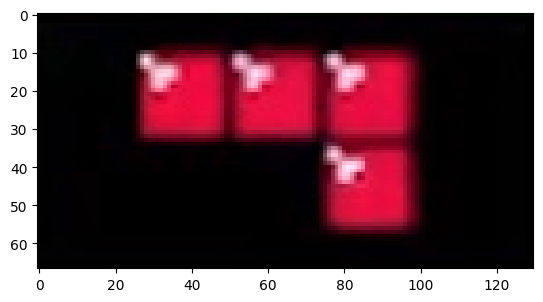

In [1087]:
x_image = cv2.imread(f'data_{folder}/frame2.jpg')
plt.imshow(x_image[6:73, 160:, :])
plt.show()

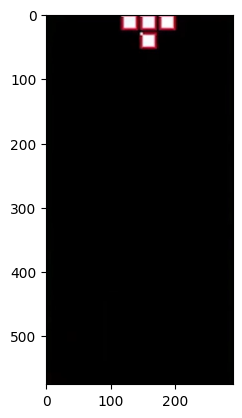

In [1088]:
x_image = cv2.imread(f'data_{folder}/frame0.jpg')
plt.imshow(x_image[99:, :, :])
plt.show()

In [1089]:
dataframe = create_current_tetromino_dataframe(data, threshold_header=99)

In [1090]:
dataframe.shape

(718, 3)

In [1091]:
dataframe_to_training_data(folder, dataframe, threshold_header=99)